<a href="https://colab.research.google.com/github/Fernando1729/zero/blob/master/bitgrit_2021_acc_67_51_rf_catboost_xgb_pca_lasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizado de máquina - Task 05


<center> <b> <font size="+2"> Viral Tweets Prediction </font> </b> </center>

<center> <i> Fernando Vieira da Silva - Nº USP: 6427452 </i> </center>
<center> <i> Mariana Menezes Gomes - Nº USP: 9790645 </i> </center>
<center> <i> Willian Ramos - Nº USP: 8936162 </i> </center>

<center> 16 de julho de 2021
 </center>

 [bitgrit link](https://bitgrit.net/competition/12#)

###Descrição original da competição:

The goal of this competition is to develop a machine learning model to predict the virality level of each tweet based on attributes such as tweet content, media attached to the tweet, and date/time published.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:.2f}'.format

drive.mount('/content/drive', force_remount=False) 
%cd /content/drive/My Drive/TASK 5/Dataset

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1tMPhs79sgIQQRIPoqGsxdFyFOmSw6svc/TASK 5/Dataset


In [ ]:
# informações referentes ao usuário
df_users = pd.read_csv('Users/users.csv')
df_user_vectorized_descriptions = pd.read_csv('Users/user_vectorized_descriptions.csv')
df_user_vectorized_profile_images = pd.read_csv('Users/user_vectorized_profile_images.csv')

# informações referentes ao tweet - treino
df_train_tweets = pd.read_csv('Tweets/train_tweets.csv')
df_train_tweets_vectorized_text = pd.read_csv('Tweets/train_tweets_vectorized_text.csv')
df_train_tweets_vectorized_media = pd.read_csv('Tweets/train_tweets_vectorized_media.csv')

# informações referentes ao tweet - teste
df_test_tweets = pd.read_csv('Tweets/test_tweets.csv')
df_test_tweets_vectorized_text = pd.read_csv('Tweets/test_tweets_vectorized_text.csv')
df_test_tweets_vectorized_media = pd.read_csv('Tweets/test_tweets_vectorized_media.csv')

# 1.Pré-processamento

## 1.1 Redução de dimensionalidade das variáveis vetorizadas

### 1.1.1 Redução de dimensionalidade de df_user_vectorized_descriptions

Verificando variância explicada de acordo com a quantidade de componentes principais:


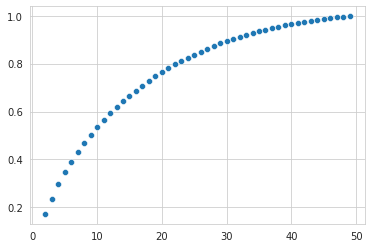

In [ ]:
from sklearn.decomposition import PCA
x = df_user_vectorized_descriptions.drop(columns='user_id')
print('Verificando variância explicada de acordo com a quantidade de componentes principais:')

list_variance = []
for k in range(2,50):
  pca = PCA(n_components=k)
  principalComponents = pca.fit_transform(x)
  list_variance.append(sum(pca.explained_variance_ratio_))

sns.set_style('whitegrid')
sns.scatterplot(range(2,50),list_variance);

Com 20 componentes principais é possível explicar $80$% da variância dos dados, de modo que selecionaremos essa quantidade. Desse modo diminuímos de $768$ atributos para $20$.

In [ ]:
from sklearn.decomposition import PCA
# redução de dimensionalidade para 20 componentes principais
x = df_user_vectorized_descriptions.drop(columns='user_id')

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
df_user_vectorized_descriptions_tmp = df_user_vectorized_descriptions.loc[:,['user_id']]
df_pc = pd.DataFrame(principalComponents)
df_pc.columns = ['user_description_pc'+str(pc) for pc in range(df_pc.shape[1])]

# atualizando df com os 20 primeiros componentes principais
df_user_vectorized_descriptions = pd.concat([df_user_vectorized_descriptions_tmp,df_pc],axis=1)

### 1.1.2 Redução de dimensionalidade de df_user_vectorized_profile_images

Verificando variância explicada de acordo com a quantidade de componentes principais:


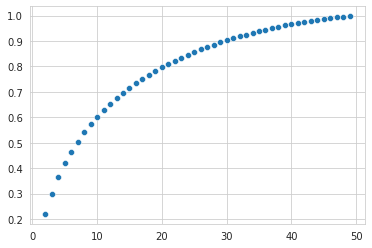

In [ ]:
from sklearn.decomposition import PCA
x = df_user_vectorized_profile_images.drop(columns='user_id')
print('Verificando variância explicada de acordo com a quantidade de componentes principais:')

list_variance = []
for k in range(2,50):
  pca = PCA(n_components=k)
  principalComponents = pca.fit_transform(x)
  list_variance.append(sum(pca.explained_variance_ratio_))

sns.set_style('whitegrid')
sns.scatterplot(range(2,50),list_variance);

Com 20 componentes principais é possível explicar $80$% da variância dos dados, de modo que selecionaremos essa quantidade. Desse modo diminuímos de $2048$ atributos para $20$.

In [ ]:
# redução de dimensionalidade para 20 componentes principais
x = df_user_vectorized_profile_images.drop(columns='user_id')

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(x)
df_user_vectorized_profile_images_tmp = df_user_vectorized_profile_images.loc[:,['user_id']]
df_pc = pd.DataFrame(principalComponents)
df_pc.columns = ['user_profile_images_pc'+str(pc) for pc in range(df_pc.shape[1])]

# atualizando df com os 20 primeiros componentes principais
df_user_vectorized_profile_images = pd.concat([df_user_vectorized_profile_images_tmp,df_pc],axis=1)

### 1.1.3 Redução de dimensionalidade de tweets_vectorized_text (train e test)

In [ ]:
# TREINO
from sklearn.decomposition import PCA
x = df_train_tweets_vectorized_text.drop(columns='tweet_id')
print('Verificando variância explicada de acordo com a quantidade de componentes principais:')

list_variance = []
for k in range(2,100):
  pca = PCA(n_components=k)
  principalComponents = pca.fit_transform(x)
  list_variance.append(sum(pca.explained_variance_ratio_))

sns.set_style('whitegrid')
sns.scatterplot(range(2,100),list_variance);

Com 80 componentes principais é possível explicar $80$% da variância dos dados, de modo que selecionaremos essa quantidade. Desse modo diminuímos de $768$ atributos para $80$.

In [ ]:
# TREINO
# redução de dimensionalidade para 80 componentes principais
x = df_train_tweets_vectorized_text.drop(columns='tweet_id')

pca = PCA(n_components=80)
principalComponents = pca.fit_transform(x)
df_train_tweets_vectorized_text_tmp = df_train_tweets_vectorized_text.loc[:,['tweet_id']]
df_pc = pd.DataFrame(principalComponents)
df_pc.columns = ['tweets_text_pc'+str(pc) for pc in range(df_pc.shape[1])]

# atualizando df com os 20 primeiros componentes principais
df_train_tweets_vectorized_text = pd.concat([df_train_tweets_vectorized_text_tmp,df_pc],axis=1)

In [ ]:
# TESTE
from sklearn.decomposition import PCA
x = df_test_tweets_vectorized_text.drop(columns='tweet_id')
print('Verificando variância explicada de acordo com a quantidade de componentes principais:')

list_variance = []
for k in range(2,100):
  pca = PCA(n_components=k)
  principalComponents = pca.fit_transform(x)
  list_variance.append(sum(pca.explained_variance_ratio_))

sns.set_style('whitegrid')
sns.scatterplot(range(2,100),list_variance);

Com 80 componentes principais é possível explicar $80$% da variância dos dados, de modo que selecionaremos essa quantidade. Desse modo diminuímos de $768$ atributos para $80$.

In [ ]:
# TESTE
# redução de dimensionalidade para 80 componentes principais
x = df_test_tweets_vectorized_text.drop(columns='tweet_id')

pca = PCA(n_components=80)
principalComponents = pca.fit_transform(x)
df_test_tweets_vectorized_text_tmp = df_test_tweets_vectorized_text.loc[:,['tweet_id']]
df_pc = pd.DataFrame(principalComponents)
df_pc.columns = ['tweets_text_pc'+str(pc) for pc in range(df_pc.shape[1])]

# atualizando df com os 80 primeiros componentes principais
df_test_tweets_vectorized_text = pd.concat([df_test_tweets_vectorized_text_tmp,df_pc],axis=1)

## 1.2 Unindo DataFrames

In [ ]:
# criação de uma variável de idade da conta

def func_user_creation_age(x): # em anos
  month = x.user_created_at_month
  month = str(month).zfill(2)
  year = str(x.user_created_at_year)

  creation_dt = datetime.strptime(month+'-'+year, "%m-%Y")  

  return (datetime.today() - creation_dt).days/365

df_users.loc[:,'user_creation_age'] = df_users.apply(func_user_creation_age,axis=1) 

In [ ]:
df_users.shape

(52, 12)

A seguir iremos concatenar os dados referentes aos usuários na mesma base dos dados referentes aos tweets.

In [ ]:
# unindo dados dos usuários em uma base só, no user_id
df_user = df_users.merge(df_user_vectorized_descriptions, on='user_id', how = 'left')
df_user = df_user.merge(df_user_vectorized_profile_images, on='user_id', how = 'left')

In [ ]:
df_user.shape

(52, 2828)

In [ ]:
# unindo dados dos tweets em uma base só, no tweet_id --- TREINO
df_train = df_train_tweets.merge(df_train_tweets_vectorized_text, on='tweet_id', how = 'left')

# unindo dados dos tweets com dados dos usuários na base de treino
df_train = df_train.rename(columns={'tweet_user_id':'user_id'})
df_train = df_user.merge(df_train, on='user_id', how='left')
df = df_train.copy()

In [ ]:
df.shape

(29625, 3609)

In [ ]:
# unindo dados dos tweets em uma base só, no tweet_id --- TESTE
df_test = df_test_tweets.merge(df_test_tweets_vectorized_text, on='tweet_id', how = 'left')

# unindo dados dos tweets com dados dos usuários na base de teste
df_test = df_test.rename(columns={'tweet_user_id':'user_id'})
df_test = df_user.merge(df_test, on='user_id', how='left')

In [ ]:
# criando variável para indicar se o tweet possui imagens
list_tweets_with_media_train = df_train_tweets_vectorized_media.tweet_id.unique()
#list_tweets_with_media_test = df_test_tweets_vectorized_media.tweet_id.unique()

df_train.loc[df_train.tweet_id.isin(list_tweets_with_media_train),'has_media'] = '1'
#df_test.loc[df_test.tweet_id.isin(list_tweets_with_media_test),'has_media'] = '1'

# 2. Análise Exploratória

## 2.1 Perfil dos Usuários

In [ ]:
df_tmp = df_train.groupby('user_id').size() # df_tmp: df temporário

print('Quantidade de tweets por usuário:')
df_tmp = df_train.groupby('user_id').size().reset_index().rename(columns={0:'n_tweets'})
display(df_tmp.n_tweets.describe().reset_index())

Quantidade de tweets por usuário:


,index,n_tweets
0,count,52.00
1,mean,569.71
2,std,84.65
3,min,113.00
4,25%,571.00
5,50%,588.00
6,75%,597.25
7,max,614.00


In [ ]:
print("Características dos usuários:")
df_users[['user_like_count','user_followers_count','user_following_count',
          'user_listed_on_count','user_tweet_count','user_creation_age']].describe()

Características dos usuários:


,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_tweet_count,user_creation_age
count,52.00,52.00,52.00,52.00,52.00,52.00
mean,4673.87,245279.10,42148.58,6903.37,39396.33,9.77
std,5714.51,369796.42,158378.44,7815.72,77111.64,1.42
min,0.00,3632.00,0.00,276.00,96.00,6.71
25%,1236.00,22712.00,972.00,1860.75,6833.25,8.77
50%,2669.00,87270.50,2675.50,4329.00,12149.00,9.88
75%,6363.75,298106.25,11897.25,8935.50,29342.50,10.55
max,33091.00,1587783.00,1118149.00,38838.00,432467.00,13.46


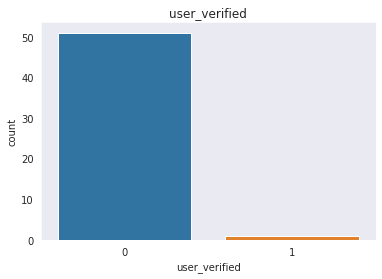

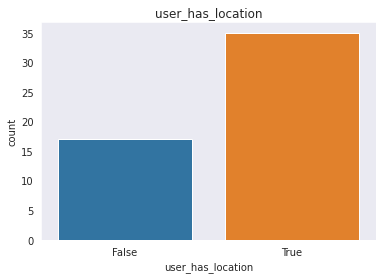

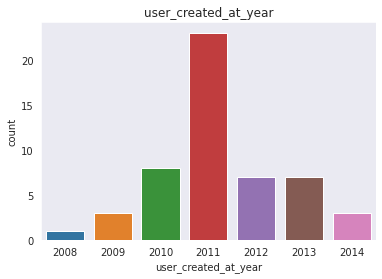

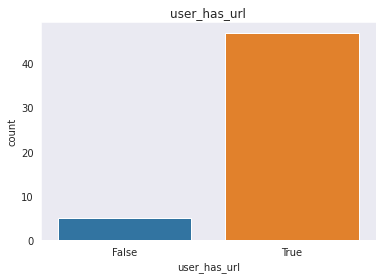

In [ ]:
for var in ['user_verified','user_has_location','user_created_at_year','user_has_url']:
  sns.countplot(x=var, data=df_users);
  plt.title(f'{var}');
  plt.show()
  print()

## 2.2 Perfil dos usuários de acordo com a viralização do tweet






In [ ]:
print('Número de usuários que já teve um determinado grau de viraliade de um tweet em algum momento:')
display(df_train.groupby('virality').agg({'user_id':pd.Series.nunique}))

Número de usuários que já teve um determinado grau de viraliade de um tweet em algum momento:


,user_id
virality,
1,49
2,52
3,50
4,47
5,47


É possível perceber que todos os usuários já tiveram um tweet com grau de viralização $2$. No geral, quase todos os usuários da base possui tweets com os $4$ graus de viralização.

Correlação entre as variáveis numéricas:



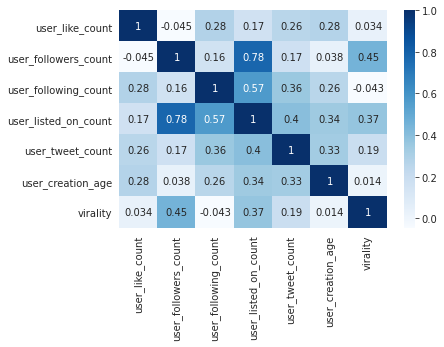

In [ ]:
import seaborn as sns
numerical_var = ['user_like_count','user_followers_count','user_following_count',
                 'user_listed_on_count','user_tweet_count','user_creation_age','virality']

print('Correlação entre as variáveis numéricas:\n')
corrMatrix = df_train.loc[:,numerical_var].corr()
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

Nota-se que a variável referente ao usuário com maior correlação com a viralização do tweet é a quantidade de seguidores da conta, seguida por usuários listados na conta.

Grau de viralização do tweet por variável de user_verified da conta:


virality,1,2,3,4,5
user_verified,,,,,
0,13525,8884,4645,1135,1323
1,107,5,1,0,0


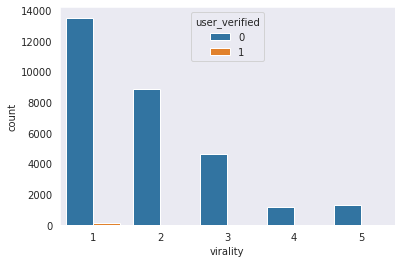

------------------------------------------------------------------------------------------------
Grau de viralização do tweet por variável de user_has_location da conta:


virality,1,2,3,4,5
user_has_location,,,,,
False,2456,2591,2778,697,968
True,11176,6298,1868,438,355


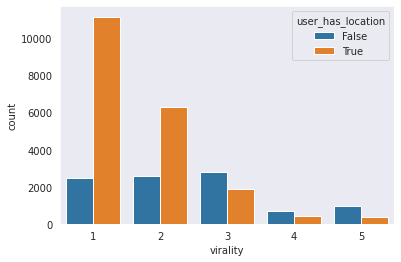

------------------------------------------------------------------------------------------------
Grau de viralização do tweet por variável de user_created_at_year da conta:


virality,1,2,3,4,5
user_created_at_year,,,,,
2008,19,135,231,84,100
2009,594,953,203,14,7
2010,1910,1676,491,196,423
2011,7572,3558,1646,333,431
2012,2055,1203,568,155,140
2013,919,1188,1398,333,213
2014,563,176,109,20,9


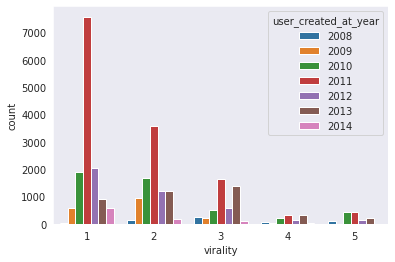

------------------------------------------------------------------------------------------------
Grau de viralização do tweet por variável de user_has_url da conta:


virality,1,2,3,4,5
user_has_url,,,,,
False,962,928,645,142,251
True,12670,7961,4001,993,1072


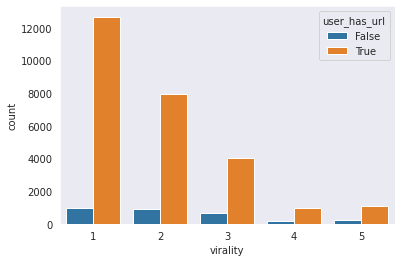

------------------------------------------------------------------------------------------------
Grau de viralização do tweet por variável de has_media da conta:


virality,1,2,3,4,5
has_media,,,,,
1,7535,5677,3059,579,586


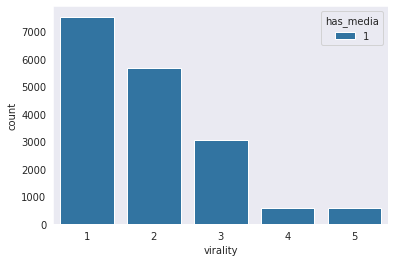

------------------------------------------------------------------------------------------------


In [ ]:
for var in ['user_verified','user_has_location','user_created_at_year','user_has_url','has_media']:

  print(f'Grau de viralização do tweet por variável de {var} da conta:')
  df_tmp = df_train.groupby([var,'virality']).agg({'tweet_id':pd.Series.nunique}).reset_index().\
                                                                                          rename(columns={'tweet_id':'n_tweets'})
  display(pd.pivot_table(df_tmp, index = var, columns = 'virality', values = 'n_tweets', aggfunc = 'sum', fill_value = 0))

  df_tmp = df_train.groupby([var,'virality','tweet_id']).size().reset_index().drop(columns=['tweet_id',0])
  sns.countplot(x="virality",hue=var, data=df_tmp);
  plt.show()
  print('------------------------------------------------------------------------------------------------')


## 2.3 Perfil dos tweets de acordo com sua viralização


Quantidade de tweets por classe de viralização:


,virality,n_tweets,proportion
0,1,13632,46.02
1,2,8889,30.01
2,3,4646,15.68
3,4,1135,3.83
4,5,1323,4.47


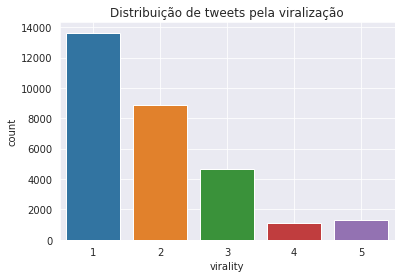

In [ ]:
# na base de df_train_tweets cada linha é um tweet
print('Quantidade de tweets por classe de viralização:')
df_tmp = df_train_tweets.groupby('virality').size().reset_index().rename(columns={0:'n_tweets'})
df_tmp.loc[:,'proportion'] = df_tmp.n_tweets/df_tmp.n_tweets.sum()*100
display(df_tmp)
print()

sns.set_style("dark")
sns.countplot(x="virality", data=df_train_tweets);
plt.title('Distribuição de tweets pela viralização');
plt.grid()
plt.show()

Correlação entre as variáveis numéricas:



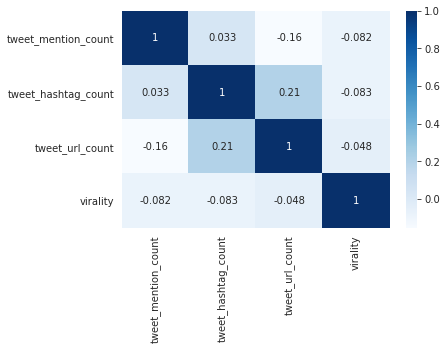

In [ ]:
import seaborn as sns
numerical_var = ['tweet_mention_count', 'tweet_hashtag_count', 'tweet_url_count','virality']

print('Correlação entre as variáveis numéricas:\n')
corrMatrix = df_train_tweets.loc[:,numerical_var].corr()
sns.heatmap(corrMatrix, annot=True, cmap='Blues')
plt.show()

A variável virality não possui uma correlação alta com nenhuma as variáveis  tweet_mention_count, tweet_hashtag_count, tweet_url_count,virality.

In [ ]:
for var in ['tweet_created_at_hour','tweet_has_attachment','tweet_language_id']:

  df_tmp = df_train_tweets.groupby(['virality',var]).size().reset_index().rename(columns={0:'n_tweet'})
  display(pd.pivot_table(df_tmp, index='virality',columns=var,values='n_tweet',aggfunc='sum', fill_value = 0))
  print('--------------------------------------------------------------------------------------------\n')

tweet_created_at_hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
virality,,,,,,,,,,,,,,,,,,,,,,,,
1,236,223,111,66,57,54,115,175,360,365,315,299,549,915,1253,1431,1431,1327,998,976,888,630,498,360
2,235,195,88,54,45,44,46,90,143,152,151,148,278,456,680,871,1091,946,709,710,564,475,390,328
3,106,95,64,34,27,23,25,54,124,170,114,130,205,282,424,402,550,483,329,281,232,214,144,134
4,21,33,18,18,10,6,7,7,22,27,13,36,42,63,113,89,145,115,72,73,74,50,40,41
5,45,42,29,16,26,17,11,12,26,24,15,26,28,71,101,118,126,127,97,97,89,76,60,44


--------------------------------------------------------------------------------------------



tweet_has_attachment,False,True
virality,,
1,5946,7686
2,3111,5778
3,1501,3145
4,537,598
5,730,593


--------------------------------------------------------------------------------------------



tweet_language_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28,29,30
virality,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,13236,63,3,170,8,5,90,5,15,7,2,2,1,3,1,1,0,1,7,2,0,0,0,4,2,0,3,0,0,1
2,8686,9,4,115,5,3,29,6,5,0,3,4,0,1,0,3,0,0,2,3,1,1,3,3,0,1,0,2,0,0
3,4511,4,0,72,6,1,33,4,2,2,2,0,0,0,0,2,1,0,1,1,0,2,0,2,0,0,0,0,0,0
4,1097,3,0,24,1,0,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,1,0,0,0
5,1244,4,0,48,2,1,4,2,0,0,1,3,0,1,0,0,1,1,1,2,3,2,0,1,0,0,0,0,1,1


--------------------------------------------------------------------------------------------



# 3. Modelos de Predição

In [ ]:
df = df_train.drop(columns='tweet_topic_ids').copy() 
df = pd.get_dummies(df)

# X, y: valores dos dados de treino
X = df.drop(columns='virality')
y = df.virality

for col in df.columns:
  if df[col].isnull().sum()>1:
    print(col)

In [ ]:
df.shape


(29625, 3611)

In [ ]:
pd.DataFrame(df).to_csv('/content/drive/My Drive/TASK 5/Dataset/data_lasso.csv')

In [ ]:
df.tail()

,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month,user_creation_age,feature_0_x,feature_1_x,feature_2_x,feature_3_x,feature_4_x,feature_5_x,feature_6_x,feature_7_x,feature_8_x,feature_9_x,feature_10_x,feature_11_x,feature_12_x,feature_13_x,feature_14_x,feature_15_x,feature_16_x,feature_17_x,feature_18_x,feature_19_x,feature_20_x,feature_21_x,feature_22_x,feature_23_x,feature_24_x,feature_25_x,feature_26_x,feature_27_x,...,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
29620,55,1299,4336,2083,705,True,2505,True,0,2014,8,6.96,0.18,-0.15,-0.02,-0.08,-0.09,0.10,-0.39,-0.31,-0.06,0.07,-0.24,0.19,-0.13,-0.23,-0.26,0.13,-0.13,-0.13,0.23,-0.32,-0.16,-0.20,-0.25,-0.17,-0.17,0.06,-0.30,0.09,...,-0.16,0.54,0.03,-0.10,0.13,-0.04,-0.14,0.21,0.22,0.02,-0.09,0.33,0.08,-0.05,-0.03,0.27,0.16,-0.21,0.00,-0.13,-0.13,-0.05,0.26,0.29,-0.48,-0.14,0.22,-0.34,-0.14,0.04,0.29,-0.09,0.11,-0.05,0.03,0.09,1,0,0,1
29621,55,1299,4336,2083,705,True,2505,True,0,2014,8,6.96,0.18,-0.15,-0.02,-0.08,-0.09,0.10,-0.39,-0.31,-0.06,0.07,-0.24,0.19,-0.13,-0.23,-0.26,0.13,-0.13,-0.13,0.23,-0.32,-0.16,-0.20,-0.25,-0.17,-0.17,0.06,-0.30,0.09,...,-0.16,0.51,-0.05,-0.18,0.09,0.02,-0.13,0.25,0.16,-0.06,-0.16,0.22,0.07,-0.07,-0.11,0.18,0.11,-0.12,0.08,-0.13,-0.00,-0.02,0.22,0.31,-0.44,-0.06,0.07,-0.29,-0.14,-0.06,0.17,-0.19,0.11,-0.14,-0.04,0.15,1,0,0,1
29622,55,1299,4336,2083,705,True,2505,True,0,2014,8,6.96,0.18,-0.15,-0.02,-0.08,-0.09,0.10,-0.39,-0.31,-0.06,0.07,-0.24,0.19,-0.13,-0.23,-0.26,0.13,-0.13,-0.13,0.23,-0.32,-0.16,-0.20,-0.25,-0.17,-0.17,0.06,-0.30,0.09,...,-0.12,0.50,0.03,-0.16,0.18,-0.09,-0.16,0.25,0.18,-0.05,-0.17,0.28,0.06,-0.04,-0.11,0.16,-0.01,-0.21,0.03,-0.21,-0.09,0.02,0.24,0.37,-0.46,-0.11,0.16,-0.28,-0.12,-0.10,0.26,-0.03,0.16,-0.07,-0.04,0.05,1,0,0,1
29623,55,1299,4336,2083,705,True,2505,True,0,2014,8,6.96,0.18,-0.15,-0.02,-0.08,-0.09,0.10,-0.39,-0.31,-0.06,0.07,-0.24,0.19,-0.13,-0.23,-0.26,0.13,-0.13,-0.13,0.23,-0.32,-0.16,-0.20,-0.25,-0.17,-0.17,0.06,-0.30,0.09,...,-0.14,0.52,0.06,-0.16,0.17,-0.06,-0.16,0.29,0.18,0.03,-0.13,0.27,0.04,0.01,-0.13,0.19,0.04,-0.14,0.02,-0.15,-0.04,0.01,0.23,0.32,-0.52,-0.03,0.10,-0.28,-0.14,-0.00,0.26,-0.11,0.10,-0.08,-0.01,0.01,1,0,0,1
29624,55,1299,4336,2083,705,True,2505,True,0,2014,8,6.96,0.18,-0.15,-0.02,-0.08,-0.09,0.10,-0.39,-0.31,-0.06,0.07,-0.24,0.19,-0.13,-0.23,-0.26,0.13,-0.13,-0.13,0.23,-0.32,-0.16,-0.20,-0.25,-0.17,-0.17,0.06,-0.30,0.09,...,-0.18,0.50,-0.05,-0.16,0.15,-0.04,-0.17,0.28,0.19,0.05,-0.21,0.25,-0.02,0.02,-0.16,0.24,0.03,-0.13,0.15,-0.16,-0.05,-0.03,0.20,0.30,-0.46,-0.16,0.20,-0.37,-0.11,0.02,0.15,-0.13,0.17,-0.11,0.04,0.02,1,0,0,1


In [ ]:
df.shape

(29625, 147)

In [ ]:
df = pd.read_csv('data_0.csv')

In [ ]:
# X, y: valores dos dados de treino
X = df.drop(columns='virality')
y = df.virality

## 3.1 Dataframe - - - - - - data_0'

In [ ]:
pd.DataFrame(df).to_csv('/content/drive/My Drive/TASK 5/Dataset/data_0.csv')

## 3.1 Random Forest

In [ ]:
#### normalizando 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
  
RF = RandomForestClassifier()

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    RF.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(RF.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média:', np.mean(lst_accu_stratified))

Possíveis acurácias: [0.6678481012658228, 0.6761181434599156, 0.6737552742616034, 0.6708860759493671, 0.6661603375527426]
Acurácia média: 0.6709535864978904


In [ ]:
# nao normalizando
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
  
RF = RandomForestClassifier()
Xarray = np.asarray(X)
for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = Xarray[train_index], Xarray[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    RF.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(RF.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média:', np.mean(lst_accu_stratified))

Possíveis acurácias: [0.6648101265822784, 0.6724050632911392, 0.6739240506329114, 0.6737552742616034, 0.6648101265822784]
Acurácia média: 0.6699409282700423


## 3.2 xgboost

In [ ]:
# normalizando
import xgboost as xgb
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
  
XGB = xgb.XGBClassifier(tree_method = 'gpu_hist')

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    XGB.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(XGB.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média:', np.mean(lst_accu_stratified))

Possíveis acurácias: [0.6470886075949367, 0.6570464135021097, 0.6592405063291139, 0.6524894514767933, 0.6462447257383966]
Acurácia média: 0.6524219409282701


In [ ]:
# nao normalizando
import xgboost as xgb
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

Xarray = np.asarray(X)
  
XGB = xgb.XGBClassifier(tree_method = 'gpu_hist')

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = Xarray[train_index], Xarray[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    XGB.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(XGB.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média:', np.mean(lst_accu_stratified))

Possíveis acurácias: [0.6450632911392405, 0.6568776371308017, 0.6577215189873418, 0.6524894514767933, 0.6469198312236287]
Acurácia média: 0.6518143459915612


## 3.2 Cat Boost

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 54kB/s 


In [ ]:
#normalizando

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []

scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(X)
  
CAT = CatBoostClassifier(task_type="GPU")

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    CAT.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(CAT.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média     :', np.mean(lst_accu_stratified))

In [ ]:
# nao normalizando
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
  
Xarray = np.asarray(X)
  
CAT = CatBoostClassifier(task_type="GPU")

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = Xarray[train_index], Xarray[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    CAT.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(CAT.score(x_test_fold, y_test_fold))

print('Possíveis acurácias:', lst_accu_stratified)
print('Acurácia média     :', np.mean(lst_accu_stratified))

# LASSO ( outra opção de redução de dimensionalidade )

In [ ]:
df = pd.read_csv('data_lasso.csv')

In [ ]:
df.shape

(29625, 3612)

# LASSO

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [ ]:
data = df
data.shape

(29625, 3612)

In [ ]:
data.head()

,Unnamed: 0,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month,user_creation_age,feature_0_x,feature_1_x,feature_2_x,feature_3_x,feature_4_x,feature_5_x,feature_6_x,feature_7_x,feature_8_x,feature_9_x,feature_10_x,feature_11_x,feature_12_x,feature_13_x,feature_14_x,feature_15_x,feature_16_x,feature_17_x,feature_18_x,feature_19_x,feature_20_x,feature_21_x,feature_22_x,feature_23_x,feature_24_x,feature_25_x,feature_26_x,...,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
0,0,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.14,0.53,0.01,-0.16,0.13,-0.10,-0.11,0.25,0.22,-0.02,-0.13,0.29,0.07,-0.05,-0.12,0.23,0.00,-0.19,-0.01,-0.21,-0.07,0.07,0.25,0.34,-0.49,-0.07,0.14,-0.30,-0.17,0.08,0.22,-0.05,0.12,-0.19,0.02,0.07,1,0,0,1
1,1,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.22,0.51,-0.05,-0.16,0.19,-0.05,-0.20,0.27,0.26,-0.05,-0.19,0.31,0.01,-0.06,-0.17,0.16,-0.02,-0.18,-0.02,-0.19,-0.06,0.03,0.27,0.40,-0.52,-0.15,0.20,-0.34,-0.09,0.02,0.16,-0.03,0.17,-0.09,-0.04,0.08,1,0,0,1
2,2,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.10,0.51,0.06,-0.15,0.21,-0.10,-0.17,0.25,0.18,-0.08,-0.09,0.24,-0.01,0.08,-0.13,0.20,0.06,-0.10,0.01,-0.29,-0.04,0.00,0.19,0.27,-0.54,-0.07,0.24,-0.34,-0.11,0.04,0.20,-0.04,0.14,-0.17,-0.06,0.08,1,0,0,1
3,3,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.22,0.44,-0.09,-0.12,-0.02,-0.06,0.03,0.14,0.06,-0.11,-0.11,0.26,-0.01,-0.03,-0.14,0.04,-0.19,-0.02,-0.11,-0.20,0.01,-0.16,0.19,0.12,-0.55,-0.21,0.24,-0.44,-0.26,0.09,0.34,-0.05,0.01,-0.08,0.08,0.05,0,0,1,0
4,4,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.13,0.53,0.02,-0.21,0.18,-0.13,-0.20,0.22,0.19,-0.01,-0.15,0.33,0.04,-0.03,-0.16,0.20,-0.01,-0.12,0.05,-0.17,-0.03,0.05,0.22,0.30,-0.50,-0.07,0.13,-0.32,-0.14,-0.04,0.17,-0.04,0.15,-0.14,-0.04,0.03,1,0,0,1


In [ ]:
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)


In [ ]:
data_0 = data

In [ ]:
#data = data_0

In [ ]:
data_N = data[numerical_vars]
data_N.shape

(29625, 3609)

In [ ]:
#data = data_N

In [ ]:
data.head()

,Unnamed: 0,user_id,user_like_count,user_followers_count,user_following_count,user_listed_on_count,user_has_location,user_tweet_count,user_has_url,user_verified,user_created_at_year,user_created_at_month,user_creation_age,feature_0_x,feature_1_x,feature_2_x,feature_3_x,feature_4_x,feature_5_x,feature_6_x,feature_7_x,feature_8_x,feature_9_x,feature_10_x,feature_11_x,feature_12_x,feature_13_x,feature_14_x,feature_15_x,feature_16_x,feature_17_x,feature_18_x,feature_19_x,feature_20_x,feature_21_x,feature_22_x,feature_23_x,feature_24_x,feature_25_x,feature_26_x,...,feature_732,feature_733,feature_734,feature_735,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
0,0,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.14,0.53,0.01,-0.16,0.13,-0.10,-0.11,0.25,0.22,-0.02,-0.13,0.29,0.07,-0.05,-0.12,0.23,0.00,-0.19,-0.01,-0.21,-0.07,0.07,0.25,0.34,-0.49,-0.07,0.14,-0.30,-0.17,0.08,0.22,-0.05,0.12,-0.19,0.02,0.07,1,0,0,1
1,1,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.22,0.51,-0.05,-0.16,0.19,-0.05,-0.20,0.27,0.26,-0.05,-0.19,0.31,0.01,-0.06,-0.17,0.16,-0.02,-0.18,-0.02,-0.19,-0.06,0.03,0.27,0.40,-0.52,-0.15,0.20,-0.34,-0.09,0.02,0.16,-0.03,0.17,-0.09,-0.04,0.08,1,0,0,1
2,2,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.10,0.51,0.06,-0.15,0.21,-0.10,-0.17,0.25,0.18,-0.08,-0.09,0.24,-0.01,0.08,-0.13,0.20,0.06,-0.10,0.01,-0.29,-0.04,0.00,0.19,0.27,-0.54,-0.07,0.24,-0.34,-0.11,0.04,0.20,-0.04,0.14,-0.17,-0.06,0.08,1,0,0,1
3,3,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.22,0.44,-0.09,-0.12,-0.02,-0.06,0.03,0.14,0.06,-0.11,-0.11,0.26,-0.01,-0.03,-0.14,0.04,-0.19,-0.02,-0.11,-0.20,0.01,-0.16,0.19,0.12,-0.55,-0.21,0.24,-0.44,-0.26,0.09,0.34,-0.05,0.01,-0.08,0.08,0.05,0,0,1,0
4,4,0,1164,48720,70469,5956,True,14122,True,0,2010,8,10.96,0.13,-0.14,-0.06,-0.12,-0.13,0.05,-0.42,-0.31,0.05,0.04,-0.21,0.16,-0.12,-0.17,-0.18,0.16,-0.12,-0.16,0.21,-0.35,-0.18,-0.08,-0.23,-0.23,-0.21,0.10,-0.20,...,-0.13,0.53,0.02,-0.21,0.18,-0.13,-0.20,0.22,0.19,-0.01,-0.15,0.33,0.04,-0.03,-0.16,0.20,-0.01,-0.12,0.05,-0.17,-0.03,0.05,0.22,0.30,-0.50,-0.07,0.13,-0.32,-0.14,-0.04,0.17,-0.04,0.15,-0.14,-0.04,0.03,1,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['virality'], axis = 1),
    data['virality'],
    test_size = 0.2,
    random_state = 1729)

X_train.shape, X_test.shape

((23700, 3611), (5925, 3611))

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
#X, y = datasets.load_iris(return_X_y=True)
#OneVsRestClassifier(LinearSVC(random_state = 0)).fit(X_train, y_train).predict(X)

In [ ]:
%%time

sel_ = SelectFromModel(OneVsRestClassifier(LogisticRegression(C=1, penalty='l1', solver='liblinear')))

sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

CPU times: user 10min 11s, sys: 4.24 s, total: 10min 15s
Wall time: 10min 12s


In [ ]:
sel_.get_support()

array([False, False, False, ...,  True,  True,  True])

In [ ]:
X_train.shape

(23700, 3611)

In [ ]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
#print('features with coefficients shrank to zero: {}'.format(
#      np.sum(sel_.estimator_.coef_ == 0)))

total features: 3611
selected features: 804


In [ ]:
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

features with coefficients shrank to zero: 14644


In [ ]:
selected_feat.shape

(804,)

In [ ]:
selected_feat

Index(['user_followers_count', 'user_has_location', 'user_created_at_year',
       'feature_2_x', 'feature_49_x', 'feature_141_x', 'feature_167_x',
       'feature_203_x', 'feature_204_x', 'feature_215_x',
       ...
       'feature_762', 'feature_763', 'feature_764', 'feature_765',
       'feature_766', 'feature_767', 'tweet_attachment_class_A',
       'tweet_attachment_class_B', 'tweet_attachment_class_C', 'has_media_1'],
      dtype='object', length=804)

In [ ]:
sel_.estimator_.coef_

array([[ 0.14499798,  0.08934794,  0.02970289, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07175824, -0.0083515 , -0.02664402, ...,  0.        ,
         0.        ,  0.        ],
       [-0.17100486, -0.05467967,  0.0112008 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.04444843, -0.12143046,  0.00552675, ...,  0.        ,
         0.        ,  0.        ],
       [-0.1643129 ,  0.04103335,  0.03648849, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
np.sum(sel_.estimator_.coef_ == 0)

14644

In [ ]:
X_all_columns = X_train.columns
X_all_columns

Index(['Unnamed: 0', 'user_id', 'user_like_count', 'user_followers_count',
       'user_following_count', 'user_listed_on_count', 'user_has_location',
       'user_tweet_count', 'user_has_url', 'user_verified',
       ...
       'feature_762', 'feature_763', 'feature_764', 'feature_765',
       'feature_766', 'feature_767', 'tweet_attachment_class_A',
       'tweet_attachment_class_B', 'tweet_attachment_class_C', 'has_media_1'],
      dtype='object', length=3611)

In [ ]:
selected_feat

Index(['user_followers_count', 'user_has_location', 'user_created_at_year',
       'feature_2_x', 'feature_49_x', 'feature_141_x', 'feature_167_x',
       'feature_203_x', 'feature_204_x', 'feature_215_x',
       ...
       'feature_762', 'feature_763', 'feature_764', 'feature_765',
       'feature_766', 'feature_767', 'tweet_attachment_class_A',
       'tweet_attachment_class_B', 'tweet_attachment_class_C', 'has_media_1'],
      dtype='object', length=804)

In [ ]:
X_lasso = X_train[selected_feat]

In [ ]:
X_train[selected_feat].head()

,user_followers_count,user_has_location,user_created_at_year,feature_2_x,feature_49_x,feature_141_x,feature_167_x,feature_203_x,feature_204_x,feature_215_x,feature_227_x,feature_252_x,feature_271_x,feature_288_x,feature_302_x,feature_386_x,feature_397_x,feature_421_x,feature_511_x,feature_583_x,feature_585_x,feature_606_x,feature_679_x,feature_697_x,feature_701_x,feature_766_x,feature_8_y,feature_388_y,feature_441_y,feature_527_y,feature_867,feature_887,feature_1155,feature_1217,feature_1271,feature_1279,feature_1322,feature_1399,feature_1424,feature_1464,...,feature_731,feature_732,feature_733,feature_734,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
9286,39177,True,2009,-0.09,-0.06,-0.01,0.12,0.24,0.07,0.15,-0.11,-0.19,0.18,-0.13,-0.03,-0.09,-0.12,0.29,0.25,-0.10,0.06,0.13,-0.14,0.22,-0.06,0.03,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.01,0.00,0.00,...,-0.25,-0.12,0.50,0.04,0.19,-0.03,-0.13,0.21,0.29,-0.04,-0.15,0.31,0.10,-0.01,-0.12,0.21,0.00,-0.23,0.02,-0.17,-0.10,0.02,0.25,0.23,-0.47,0.02,0.18,-0.30,-0.15,-0.01,0.16,0.08,0.17,-0.12,-0.02,-0.02,0,0,1,0
8609,19671,True,2011,-0.06,-0.10,-0.01,0.20,0.16,0.01,0.12,-0.23,-0.17,0.15,-0.11,-0.05,-0.13,-0.05,0.31,0.23,-0.14,0.15,0.15,-0.18,0.20,-0.11,-0.03,0.00,0.00,0.01,0.18,0.00,0.00,0.00,0.18,0.02,0.00,0.88,0.00,0.23,0.02,...,-0.31,-0.10,0.47,0.02,0.21,-0.04,-0.09,0.21,0.16,-0.10,-0.09,0.33,-0.04,-0.03,-0.12,0.16,0.06,-0.15,-0.05,-0.15,-0.11,-0.10,0.23,0.40,-0.45,-0.06,0.18,-0.37,-0.10,0.04,0.10,-0.00,0.12,-0.09,-0.13,0.15,1,0,0,1
7956,1049348,True,2012,-0.05,-0.11,0.06,0.05,0.24,-0.01,0.16,-0.13,-0.12,0.14,-0.12,-0.05,-0.14,-0.11,0.29,0.27,-0.15,0.07,0.14,-0.06,0.26,-0.07,-0.09,0.00,0.00,0.07,0.64,0.00,0.00,0.00,0.00,0.00,0.00,2.19,0.01,0.00,0.00,...,-0.21,-0.17,0.56,-0.04,0.12,-0.05,-0.09,0.21,0.28,-0.02,-0.26,0.27,0.08,-0.07,-0.14,0.21,0.04,-0.22,0.05,-0.25,-0.06,0.10,0.14,0.31,-0.50,-0.22,0.25,-0.34,-0.17,-0.10,0.22,0.01,0.20,-0.15,-0.03,0.16,0,0,1,0
12730,32895,True,2011,-0.01,-0.03,0.00,0.13,0.20,0.02,0.18,-0.18,-0.16,0.22,-0.13,-0.05,-0.07,-0.11,0.30,0.27,-0.07,0.13,0.19,-0.06,0.17,-0.09,0.02,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.65,0.02,0.00,0.02,...,-0.28,-0.18,0.52,0.01,0.12,-0.06,-0.11,0.16,0.22,-0.07,-0.14,0.36,0.03,0.01,-0.14,0.25,0.05,-0.14,0.05,-0.21,-0.07,0.03,0.23,0.31,-0.49,-0.20,0.08,-0.36,-0.15,-0.05,0.22,-0.05,0.11,-0.19,-0.03,0.07,1,0,0,1
10695,16672,True,2010,0.02,-0.01,-0.01,0.13,0.29,0.03,0.15,-0.14,-0.23,0.22,-0.07,-0.02,-0.06,-0.12,0.26,0.19,-0.04,0.09,0.17,-0.11,0.18,-0.02,0.05,0.00,0.00,0.00,0.07,0.00,0.01,0.00,0.09,0.00,0.00,1.34,0.08,0.27,0.00,...,-0.24,-0.09,0.50,0.06,0.16,-0.07,-0.16,0.18,0.23,-0.01,-0.11,0.30,0.04,0.02,-0.15,0.18,0.04,-0.13,0.04,-0.23,-0.07,0.00,0.27,0.27,-0.47,-0.07,0.14,-0.34,-0.17,0.02,0.22,0.01,0.11,-0.16,0.05,0.04,0,0,1,0


In [ ]:
X_lasso.shape

(23700, 804)

In [ ]:
X_lasso.head()

,user_followers_count,user_has_location,user_created_at_year,feature_2_x,feature_49_x,feature_141_x,feature_167_x,feature_203_x,feature_204_x,feature_215_x,feature_227_x,feature_252_x,feature_271_x,feature_288_x,feature_302_x,feature_386_x,feature_397_x,feature_421_x,feature_511_x,feature_583_x,feature_585_x,feature_606_x,feature_679_x,feature_697_x,feature_701_x,feature_766_x,feature_8_y,feature_388_y,feature_441_y,feature_527_y,feature_867,feature_887,feature_1155,feature_1217,feature_1271,feature_1279,feature_1322,feature_1399,feature_1424,feature_1464,...,feature_731,feature_732,feature_733,feature_734,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
9286,39177,True,2009,-0.09,-0.06,-0.01,0.12,0.24,0.07,0.15,-0.11,-0.19,0.18,-0.13,-0.03,-0.09,-0.12,0.29,0.25,-0.10,0.06,0.13,-0.14,0.22,-0.06,0.03,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.01,0.00,0.00,...,-0.25,-0.12,0.50,0.04,0.19,-0.03,-0.13,0.21,0.29,-0.04,-0.15,0.31,0.10,-0.01,-0.12,0.21,0.00,-0.23,0.02,-0.17,-0.10,0.02,0.25,0.23,-0.47,0.02,0.18,-0.30,-0.15,-0.01,0.16,0.08,0.17,-0.12,-0.02,-0.02,0,0,1,0
8609,19671,True,2011,-0.06,-0.10,-0.01,0.20,0.16,0.01,0.12,-0.23,-0.17,0.15,-0.11,-0.05,-0.13,-0.05,0.31,0.23,-0.14,0.15,0.15,-0.18,0.20,-0.11,-0.03,0.00,0.00,0.01,0.18,0.00,0.00,0.00,0.18,0.02,0.00,0.88,0.00,0.23,0.02,...,-0.31,-0.10,0.47,0.02,0.21,-0.04,-0.09,0.21,0.16,-0.10,-0.09,0.33,-0.04,-0.03,-0.12,0.16,0.06,-0.15,-0.05,-0.15,-0.11,-0.10,0.23,0.40,-0.45,-0.06,0.18,-0.37,-0.10,0.04,0.10,-0.00,0.12,-0.09,-0.13,0.15,1,0,0,1
7956,1049348,True,2012,-0.05,-0.11,0.06,0.05,0.24,-0.01,0.16,-0.13,-0.12,0.14,-0.12,-0.05,-0.14,-0.11,0.29,0.27,-0.15,0.07,0.14,-0.06,0.26,-0.07,-0.09,0.00,0.00,0.07,0.64,0.00,0.00,0.00,0.00,0.00,0.00,2.19,0.01,0.00,0.00,...,-0.21,-0.17,0.56,-0.04,0.12,-0.05,-0.09,0.21,0.28,-0.02,-0.26,0.27,0.08,-0.07,-0.14,0.21,0.04,-0.22,0.05,-0.25,-0.06,0.10,0.14,0.31,-0.50,-0.22,0.25,-0.34,-0.17,-0.10,0.22,0.01,0.20,-0.15,-0.03,0.16,0,0,1,0
12730,32895,True,2011,-0.01,-0.03,0.00,0.13,0.20,0.02,0.18,-0.18,-0.16,0.22,-0.13,-0.05,-0.07,-0.11,0.30,0.27,-0.07,0.13,0.19,-0.06,0.17,-0.09,0.02,0.00,0.00,0.42,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.65,0.02,0.00,0.02,...,-0.28,-0.18,0.52,0.01,0.12,-0.06,-0.11,0.16,0.22,-0.07,-0.14,0.36,0.03,0.01,-0.14,0.25,0.05,-0.14,0.05,-0.21,-0.07,0.03,0.23,0.31,-0.49,-0.20,0.08,-0.36,-0.15,-0.05,0.22,-0.05,0.11,-0.19,-0.03,0.07,1,0,0,1
10695,16672,True,2010,0.02,-0.01,-0.01,0.13,0.29,0.03,0.15,-0.14,-0.23,0.22,-0.07,-0.02,-0.06,-0.12,0.26,0.19,-0.04,0.09,0.17,-0.11,0.18,-0.02,0.05,0.00,0.00,0.00,0.07,0.00,0.01,0.00,0.09,0.00,0.00,1.34,0.08,0.27,0.00,...,-0.24,-0.09,0.50,0.06,0.16,-0.07,-0.16,0.18,0.23,-0.01,-0.11,0.30,0.04,0.02,-0.15,0.18,0.04,-0.13,0.04,-0.23,-0.07,0.00,0.27,0.27,-0.47,-0.07,0.14,-0.34,-0.17,0.02,0.22,0.01,0.11,-0.16,0.05,0.04,0,0,1,0


In [ ]:
True_False_lasso = pd.DataFrame(sel_.get_support())

In [ ]:
True_False_lasso.head(600)

,0
0,False
1,False
2,False
3,True
4,False
...,...
595,False
596,True
597,False
598,True


In [ ]:
LogisticRegression

In [ ]:
X_lasso_test = X_test[selected_feat]

In [ ]:
X_lasso_test.head()

,user_followers_count,user_has_location,user_created_at_year,feature_2_x,feature_49_x,feature_141_x,feature_167_x,feature_203_x,feature_204_x,feature_215_x,feature_227_x,feature_252_x,feature_271_x,feature_288_x,feature_302_x,feature_386_x,feature_397_x,feature_421_x,feature_511_x,feature_583_x,feature_585_x,feature_606_x,feature_679_x,feature_697_x,feature_701_x,feature_766_x,feature_8_y,feature_388_y,feature_441_y,feature_527_y,feature_867,feature_887,feature_1155,feature_1217,feature_1271,feature_1279,feature_1322,feature_1399,feature_1424,feature_1464,...,feature_731,feature_732,feature_733,feature_734,feature_736,feature_737,feature_738,feature_739,feature_740,feature_741,feature_742,feature_743,feature_744,feature_745,feature_746,feature_747,feature_748,feature_749,feature_750,feature_751,feature_752,feature_753,feature_754,feature_755,feature_756,feature_757,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,tweet_attachment_class_A,tweet_attachment_class_B,tweet_attachment_class_C,has_media_1
1374,200944,True,2011,-0.07,-0.07,0.01,0.07,0.26,0.07,0.14,-0.05,-0.14,0.18,-0.16,-0.03,-0.04,-0.17,0.30,0.33,-0.11,0.12,0.21,-0.02,0.23,-0.09,0.03,0.00,0.00,0.00,0.51,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.02,0.13,0.00,...,-0.18,-0.20,0.46,0.05,0.19,-0.03,-0.22,0.13,0.19,-0.11,-0.12,0.37,0.06,0.03,-0.14,0.12,0.07,-0.17,0.02,-0.25,-0.14,-0.00,0.25,0.29,-0.49,-0.16,0.28,-0.29,-0.12,0.06,0.19,-0.11,0.11,-0.14,0.01,0.06,1,0,0,1
9003,39177,True,2009,-0.09,-0.06,-0.01,0.12,0.24,0.07,0.15,-0.11,-0.19,0.18,-0.13,-0.03,-0.09,-0.12,0.29,0.25,-0.10,0.06,0.13,-0.14,0.22,-0.06,0.03,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.01,0.00,0.00,...,-0.15,-0.17,0.54,0.05,0.21,-0.03,-0.14,0.24,0.20,-0.01,-0.14,0.28,0.01,-0.04,-0.11,0.19,0.02,-0.11,-0.03,-0.25,-0.10,-0.05,0.26,0.42,-0.53,-0.09,0.21,-0.38,-0.20,-0.05,0.26,-0.07,0.11,-0.17,-0.03,0.09,1,0,0,1
4002,23127,False,2011,-0.07,-0.02,0.04,0.09,0.23,-0.00,0.19,-0.13,-0.16,0.16,-0.12,-0.06,-0.12,-0.09,0.29,0.24,-0.09,0.09,0.17,-0.00,0.23,-0.10,-0.04,0.02,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.06,0.00,1.78,0.00,0.06,0.12,...,-0.16,-0.09,0.46,0.03,0.20,-0.04,-0.05,0.22,0.19,-0.08,-0.16,0.28,0.04,-0.01,-0.10,0.14,0.06,-0.23,0.02,-0.11,-0.08,-0.02,0.26,0.38,-0.48,-0.14,0.31,-0.35,-0.11,-0.00,0.18,-0.01,0.13,-0.17,-0.06,0.08,1,0,0,1
17652,94647,True,2013,-0.04,0.02,0.08,0.04,0.18,0.04,0.10,-0.14,-0.09,0.12,-0.15,-0.12,-0.10,-0.07,0.30,0.30,-0.12,0.06,0.14,-0.04,0.19,-0.14,-0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.08,0.40,0.00,0.17,0.00,0.12,0.09,...,-0.20,-0.16,0.51,-0.05,0.14,-0.13,-0.16,0.11,0.12,-0.07,-0.09,0.40,0.01,0.08,-0.19,0.19,0.06,-0.12,0.07,-0.25,-0.14,0.07,0.23,0.26,-0.41,-0.05,0.14,-0.32,-0.21,0.06,0.18,-0.06,0.17,-0.15,-0.03,0.11,1,0,0,1
6519,1310481,True,2008,-0.03,-0.04,0.13,0.08,0.20,-0.01,0.18,-0.13,-0.14,0.20,-0.23,-0.07,-0.10,-0.08,0.34,0.29,-0.14,0.11,0.20,-0.11,0.16,-0.10,-0.07,0.00,0.29,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.41,0.01,0.00,0.00,...,-0.25,-0.18,0.45,0.01,0.20,-0.17,-0.17,0.16,0.27,-0.08,-0.15,0.27,0.08,-0.06,-0.10,0.10,-0.00,-0.12,0.02,-0.15,-0.08,0.13,0.20,0.28,-0.42,-0.16,0.24,-0.27,-0.21,-0.03,0.20,0.00,0.11,-0.11,-0.09,0.05,0,0,1,0


In [ ]:
X_lasso_test.shape

(5925, 804)

In [ ]:
!pip install catboost

     |████████████████████████████████| 69.2MB 54kB/s 


In [ ]:
# nao normalizando
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

Xarray = np.asarray(X_lasso)
Xarray_test = np.asarray(X_lasso_test)
  

In [ ]:
Xarray.shape, Xarray_test.shape

((23700, 804), (5925, 804))

In [ ]:
y_train.shape , y_test.shape

((23700,), (5925,))

In [ ]:

CAT = CatBoostClassifier(task_type="GPU")

CAT.fit(Xarray, y_train)


## CatBoost - Acurácia ( só de um único conjunto de teste, não é a média com CV )

In [ ]:
ACC = CAT.score(Xarray_test, y_test)

print('Acurácia média     :', ACC)

Acurácia média     : 0.6751054852320675


## LASSO ( propriamente dito )

In [ ]:
%%time

sel_ = SelectFromModel(OneVsRestClassifier(LogisticRegression(C=1, penalty='l1', solver='liblinear')))

sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

CPU times: user 10min 11s, sys: 4.24 s, total: 10min 15s
Wall time: 10min 12s


---